# Demonstration of X-Ray Absorption Spectroscopy

In [1]:
import sys
import os
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from cycler import cycler
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import interactive
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#default plot setting
mpl.rcParams['axes.prop_cycle'] = cycler(color='brgcmyk')
mpl.rcParams['figure.figsize'] = (8,8)
plt.rcParams['image.cmap'] = 'magma'
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.serif'] = 'Computer Modern Roman'
#mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 10


#load data
experiment_run_name = "sxrlr0716run29"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("../"+my_file,"r")

#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    try:
        my_dict[i] = array(my_hdf5_object[i])
    except:
        pass
pixel_to_femtosecond_list = []
width_list = []

#no built in type for weighted binnsed statistic, 
#might be able to use sum instead of mean (or average)
def weighted_binned_statistic(x,y,weights,bins,statistic):
    binned_weighted_statistic = binned_statistic_dd(x,y*weights,bins=[my_bins],statistic=average)
    binned_weights = binned_statistic_dd(x,1.0*weights,bins=[my_bins],statistic=average)
    
    return  binned_weighted_statistic.statistic/binned_weights.statistic

my_hdf5_object.close()

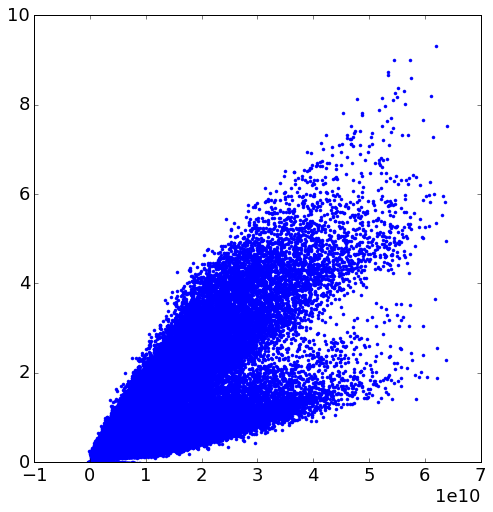

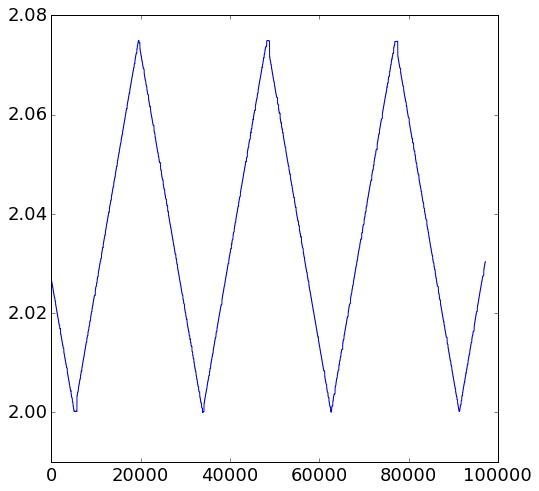

In [4]:
my_mask = -my_dict['Acq01/ch2/area']<6
#my_mask[:]=True
x = my_dict['gmd/relativeEnergyPerPulse'][my_mask]
y = -my_dict['Acq01/ch3/area'][my_mask]
z = my_dict['mono_pitch'][my_mask]
energy = my_dict['ebeam/photon_energy'][my_mask]
plot(x,y,'.',alpha=1.0)
ylim(0,10)
show()
plot(z)
show()

## standard division

In [5]:
my_bins = arange(2,2.08,.08/100.0)
binned_y = binned_statistic_dd(z,y,bins=[my_bins],statistic=mean).statistic
binned_x = binned_statistic_dd(z,x,bins=[my_bins],statistic=mean).statistic
binned_e = binned_statistic_dd(z,energy,bins=[my_bins],statistic=average).statistic


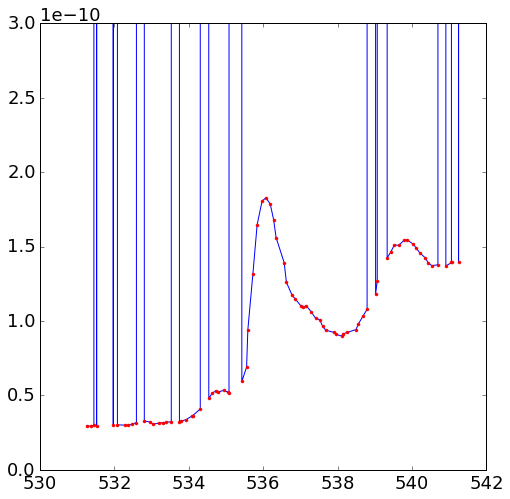

In [15]:
plot(binned_e ,binned_y*1.0/binned_x,'-')
plot(binned_e ,binned_y*1.0/binned_x,'.')
ylim(0,0.3e-9)
show()

## regression of I vs I0

In [11]:
my_bins = arange(2,2.08,.08/100.0)
def get_slope(i):
    z_start = my_bins[i]
    z_end = my_bins[i+1]
    temp_mask = z<z_end
    temp_mask = temp_mask*(z>z_start)
    #return (cov(x[temp_mask],y[temp_mask])[0,1]*1.0/var(x[temp_mask]))
    try:
        return theilslopes(y[temp_mask],x[temp_mask],alpha=0.95)[0]
    except:
        return 0

binned_slope = array([get_slope(i) for i in arange(len(my_bins)-1)])


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


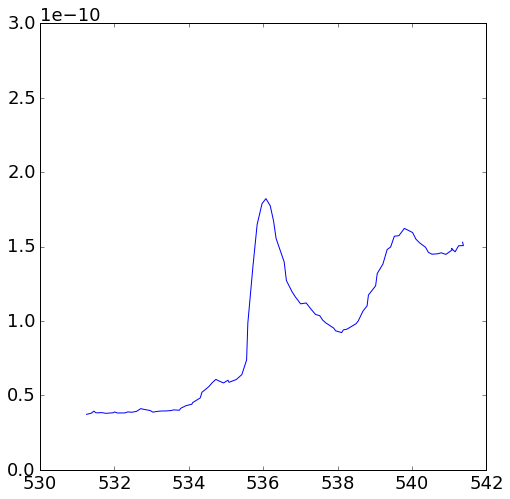

In [13]:
plot(binned_e,binned_slope,'-')
ylim(0,0.3e-9)
show()